In [1]:
import scanpy as sc
import os
import seaborn as sns
import pandas as pd
import numpy as np
import anndata as ad

import scvi
import torch
from scvi.external import CellAssign

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "/faststorage/project/projectsInBioinformatics/data/GSE202647/GSM6127766_NOA1/"

In [3]:
adata = sc.read_10x_mtx(data_dir)
adata.var_names_make_unique()
lib_size = adata.X.sum(1)
adata.obs["size_factor"] = lib_size / np.mean(lib_size)

In [4]:
adata.layers["raw_counts"] = adata.X.copy()

In [5]:
adata

AnnData object with n_obs × n_vars = 6348 × 27984
    obs: 'size_factor'
    var: 'gene_ids', 'feature_types'
    layers: 'raw_counts'

In [6]:
adata.var['mt'] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
#sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color = "pct_counts_mt")

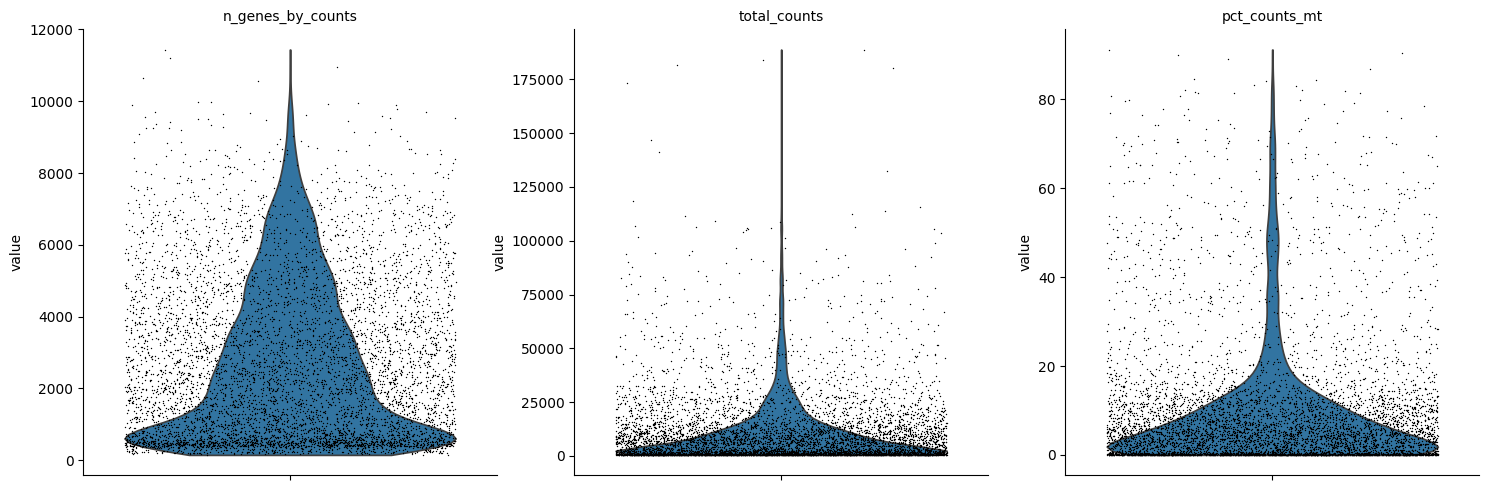

In [7]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter = 0.4, multi_panel = True)


In [8]:
sc.pp.filter_genes(adata, min_cells = 3, inplace = True)

sc.pp.filter_cells(adata, min_genes = 200, inplace = True)
sc.pp.filter_cells(adata, max_genes= 8000, inplace = True)

adata = adata[adata.obs['pct_counts_mt'] < 20].copy()

adata = adata[adata.obs['total_counts'] < 75000].copy()

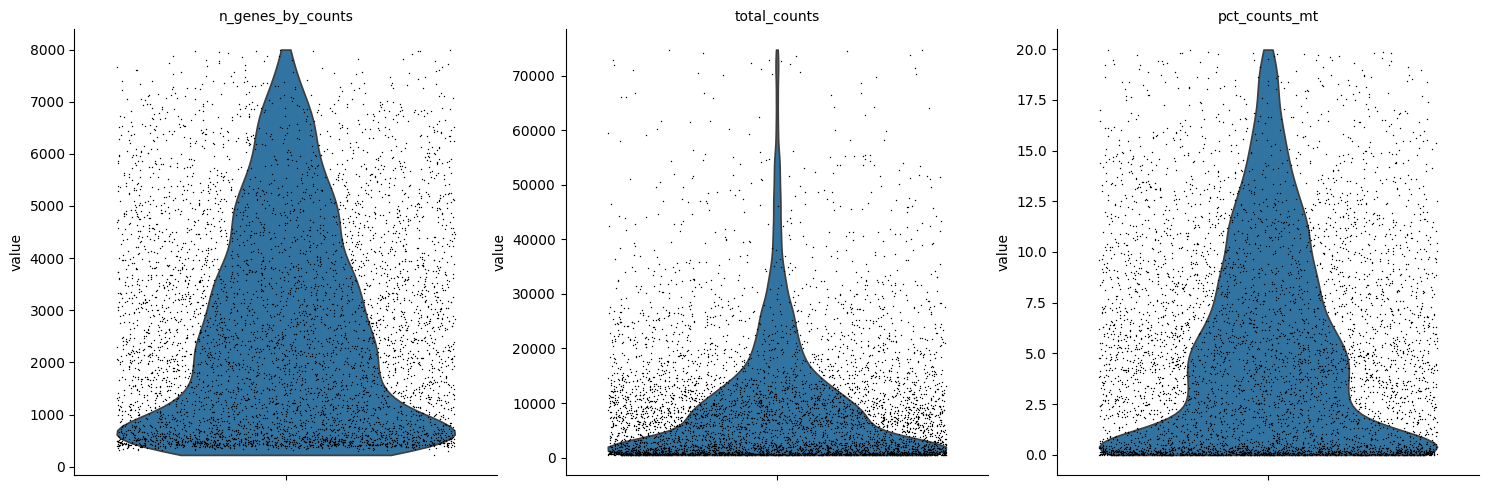

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter = 0.4, multi_panel = True)


In [10]:
adata.layers["filter_counts"] = adata.X.copy()

In [11]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)

In [12]:
sc.pp.highly_variable_genes(adata, min_mean = 0.02, max_mean = 4, min_disp = 0.5)

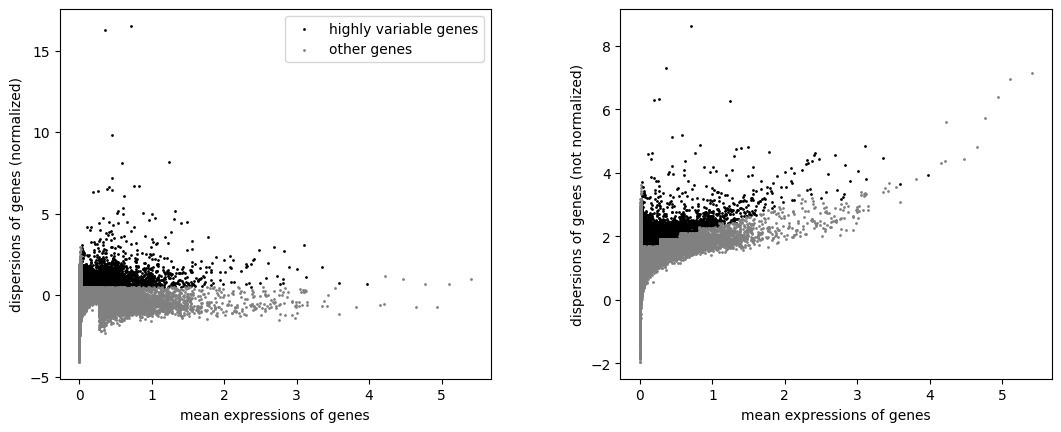

In [13]:
sc.pl.highly_variable_genes(adata)

In [14]:
np.sum(adata.var.highly_variable)

np.int64(5521)

In [15]:
sc.pp.scale(adata, max_value = 10)

/home/jool/miniforge3/envs/torch/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [16]:
adata.layers["normalised"] = adata.X.copy()

In [17]:
sc.tl.pca(adata, svd_solver = 'arpack')

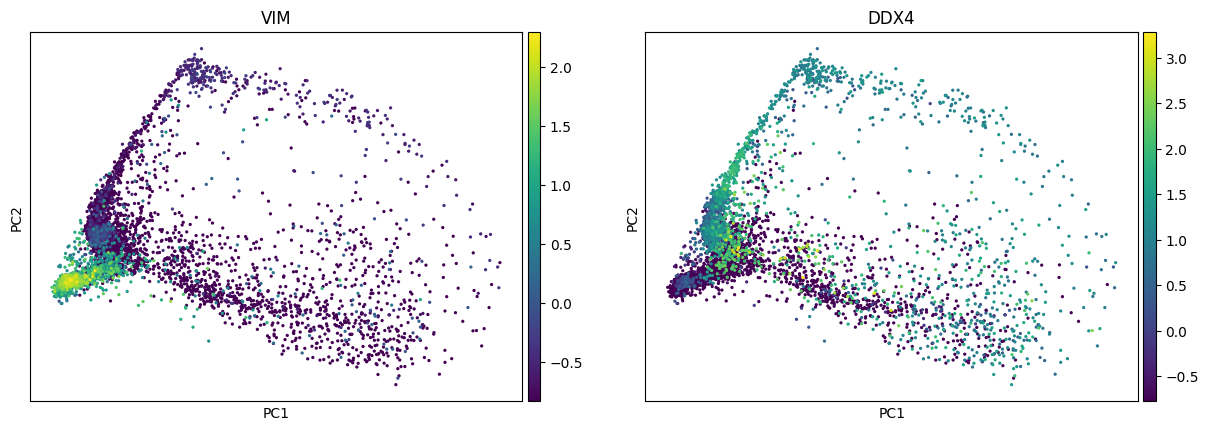

In [18]:
markers = ['VIM', 'DDX4'] #VIM: somatic cells, DDX4: spermatogonia, spermatocytes, spermatids
sc.pl.pca(adata, color = markers)

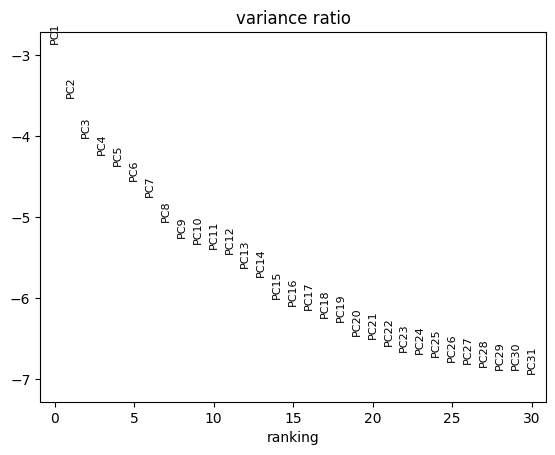

In [19]:
sc.pl.pca_variance_ratio(adata, log = True)

In [20]:
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 25)

In [21]:
sc.tl.leiden(adata, resolution = 0.5)

/tmp/6167662/ipykernel_1982237/3246266323.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5)


In [22]:
sc.tl.umap(adata, spread = 1, min_dist = 0.5, random_state = 1)

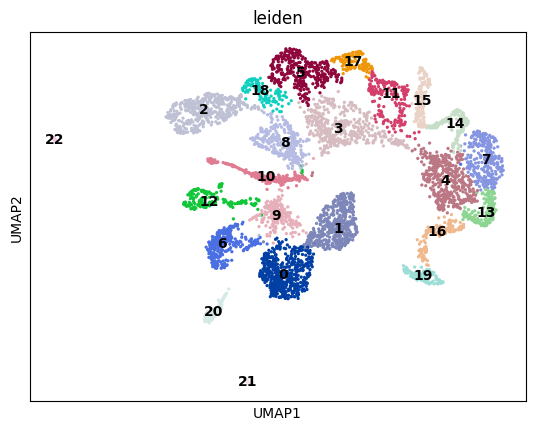

In [23]:
sc.pl.umap(adata, color = 'leiden', legend_loc = 'on data')

In [24]:
sc.tl.rank_genes_groups(adata, 'leiden', method = 't-test')

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name,

In [25]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
ranked_genes = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']})
ranked_genes.head(10)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p,14_n,14_p,15_n,15_p,16_n,16_p,17_n,17_p,18_n,18_p,19_n,19_p,20_n,20_p,21_n,21_p,22_n,22_p
0,DCN,0.0,PTGDS,0.0,DNAJB6,0.000000e+00,PRM1,1.060952e-136,HMGB4,5.249871e-219,SYCP3,0.000000e+00,TAGLN,3.952525e-323,SPACA1,4.211658e-198,PRM2,8.436491e-97,PRM2,6.838761e-97,TMSB10,3.464214e-56,SPINK2,3.042243e-177,FTL,1.801163e-98,TNP1,8.064234e-158,CMTM2,0.000000e+00,AL133499.1,0.000000e+00,CRISP2,1.826902e-228,SYCP1,2.595875e-151,PTMA,6.837614e-112,CRISP2,2.606546e-101,B2M,2.019626e-94,TFF3,6.029676e-147,B2M,2.731319e-27
1,IGFBP7,0.0,IGFBP7,0.0,HMGA1,7.726686e-317,PRM2,2.281532e-129,PRM2,5.988805e-250,SMC3,0.000000e+00,TPM2,2.743803e-266,AC092666.1,3.774586e-181,PRM1,1.676360e-92,PRM1,6.998121e-91,DEFB119,2.361917e-48,PHF7,2.358824e-160,B2M,2.460006e-96,TMEM191C,1.742676e-123,DYNLRB2,1.339906e-320,CMTM2,0.000000e+00,PRM2,3.458651e-155,TEX101,4.771502e-137,TKTL1,8.494139e-80,BOD1L2,1.430482e-112,HLA-E,2.696177e-61,B2M,3.896675e-25,CD48,7.011447e-21
2,VIM,0.0,FHL2,0.0,CCNI,0.000000e+00,TNP1,7.200322e-100,PRM1,1.204004e-196,TOP2A,1.841177e-282,ACTA2,4.791680e-264,NUPR2,3.011527e-214,TNP1,9.010597e-56,TNP1,4.355410e-72,FATE1,1.828736e-43,ANKRD7,1.160337e-156,TMSB4X,4.077759e-91,HMGB4,9.701690e-153,ROPN1L,3.416343e-296,IZUMO4,0.000000e+00,HMGB4,4.956636e-196,LY6K,2.015675e-129,NASP,5.227008e-79,DCUN1D1,7.703638e-93,TMSB4X,1.665773e-63,HLA-B,6.742945e-22,TMSB4X,4.582717e-22
3,CD81,0.0,ENG,0.0,PAFAH1B3,5.208067e-274,C5orf58,7.298429e-67,TNP1,7.714359e-165,FMR1NB,1.092339e-243,VIM,0.000000e+00,DKKL1,8.856924e-177,HMGA1,3.637681e-32,TMSB4X,4.858946e-36,CITED1,6.237823e-42,ALKBH7,1.243679e-170,TYROBP,2.534233e-74,PRM1,5.388461e-140,CDKN3,0.000000e+00,ANKRD7,0.000000e+00,PRM1,1.296675e-142,TPTE,2.881827e-129,YWHAE,3.010148e-82,NUPR2,2.559533e-94,TMSB10,9.995453e-63,ECSCR,9.611508e-20,HLA-A,2.340086e-19
4,ITM2B,0.0,TIMP2,0.0,YWHAB,0.000000e+00,SYCP1,5.956389e-45,NUPR2,1.170287e-80,SMC1B,8.028645e-234,MYL9,1.103215e-260,HMGB4,1.555525e-221,RPS12,1.115961e-31,PTGDS,5.469134e-34,APOA1,2.709215e-39,ATPIF1,8.668770e-154,HLA-DRA,5.495732e-71,PRM2,2.238930e-145,BOD1L2,0.000000e+00,CATSPERZ,0.000000e+00,LELP1,2.830516e-144,C5orf58,1.869778e-138,HERC5,5.894389e-74,LELP1,9.138245e-79,VIM,1.416271e-66,HLA-E,6.311543e-20,HLA-C,9.001887e-19
5,B2M,0.0,TMSB4X,0.0,HNRNPDL,0.000000e+00,TEX101,1.207393e-39,LINC00467,3.206625e-77,TEX101,3.085161e-230,CALD1,1.741022e-274,C20orf144,4.871981e-164,RPS19,1.343566e-25,FTL,1.723104e-27,PRM2,1.322219e-40,LDHC,3.995182e-145,CD74,1.081386e-69,LINC01921,6.611335e-103,CATSPERZ,0.000000e+00,SCCPDH,0.000000e+00,SMCP,2.606609e-157,HORMAD1,4.866224e-134,CBX3,4.418614e-83,UBE2N,1.121221e-77,MGP,1.149082e-56,HLA-C,3.027866e-20,RPL23A,1.059005e-18
6,PTGDS,0.0,SPARCL1,0.0,EGFL7,2.438773e-249,SYCP3,8.040624e-38,FAM209A,4.151543e-74,ZCWPW1,1.993799e-219,ADIRF,1.591173e-222,EQTN,2.183758e-151,RPLP0,1.748659e-22,RPL10,1.285571e-22,RNASE1,1.488111e-38,COX7A2,5.481705e-150,HLA-DPB1,6.137590e-64,C20orf144,2.601463e-87,TSACC,0.000000e+00,PPP3R2,1.292356e-257,SPTY2D1OS,1.619052e-160,SYCP3,1.057834e-139,SMC3,4.115909e-76,TPPP2,3.957233e-72,SPARCL1,3.294271e-56,TMSB10,7.288409e-20,RPS15A,7.265325e-18
7,SERPINF1,0.0,ITM2B,0.0,C1QBP,1.183569e-280,TOP2A,5.100690e-36,FAM229A,1.319559e-72,SCML1,1.050203e-210,ACTB,1.677732e-306,APH1B,2.045601e-165,RPSA,8.455027e-21,EEF1A1,2.209024e-20,PRM1,1.770717e-38,SPATA22,2.738073e-119,AIF1,6.123625e-62,NUPR2,2.298469e-98,IZUMO4,1.092641e-286,AC006012.1,5.031632e-213,DCUN1D1,4.429099e-156,TOP2A,4.036272e-119,PRAME,1.542219e-68,SMCP,6.140097e-71,HLA-C,3.046972e-53,IGFBP7,8.074690e-21,HLA-B,9.345326e-17
8,CD63,0.0,LGALS1,0.0,SOD1,0.000000e+00,HORMAD1,3.422970e-34,TSACC,8.055299e-72,HORMAD1,2.346719e-233,MYH11,2.206571e-203,ERICH2,3.597378e-161,RPS21,1.631820e-19,IGFBP7,1.482318e-18,CLU,1.549182e-34,SPATA8,4.039586e-112,HLA-DRB1,5.739808e-61,IQGAP2,2.779899e-81,PDXK,1.094634e-273,SPINK2,0.000000e+

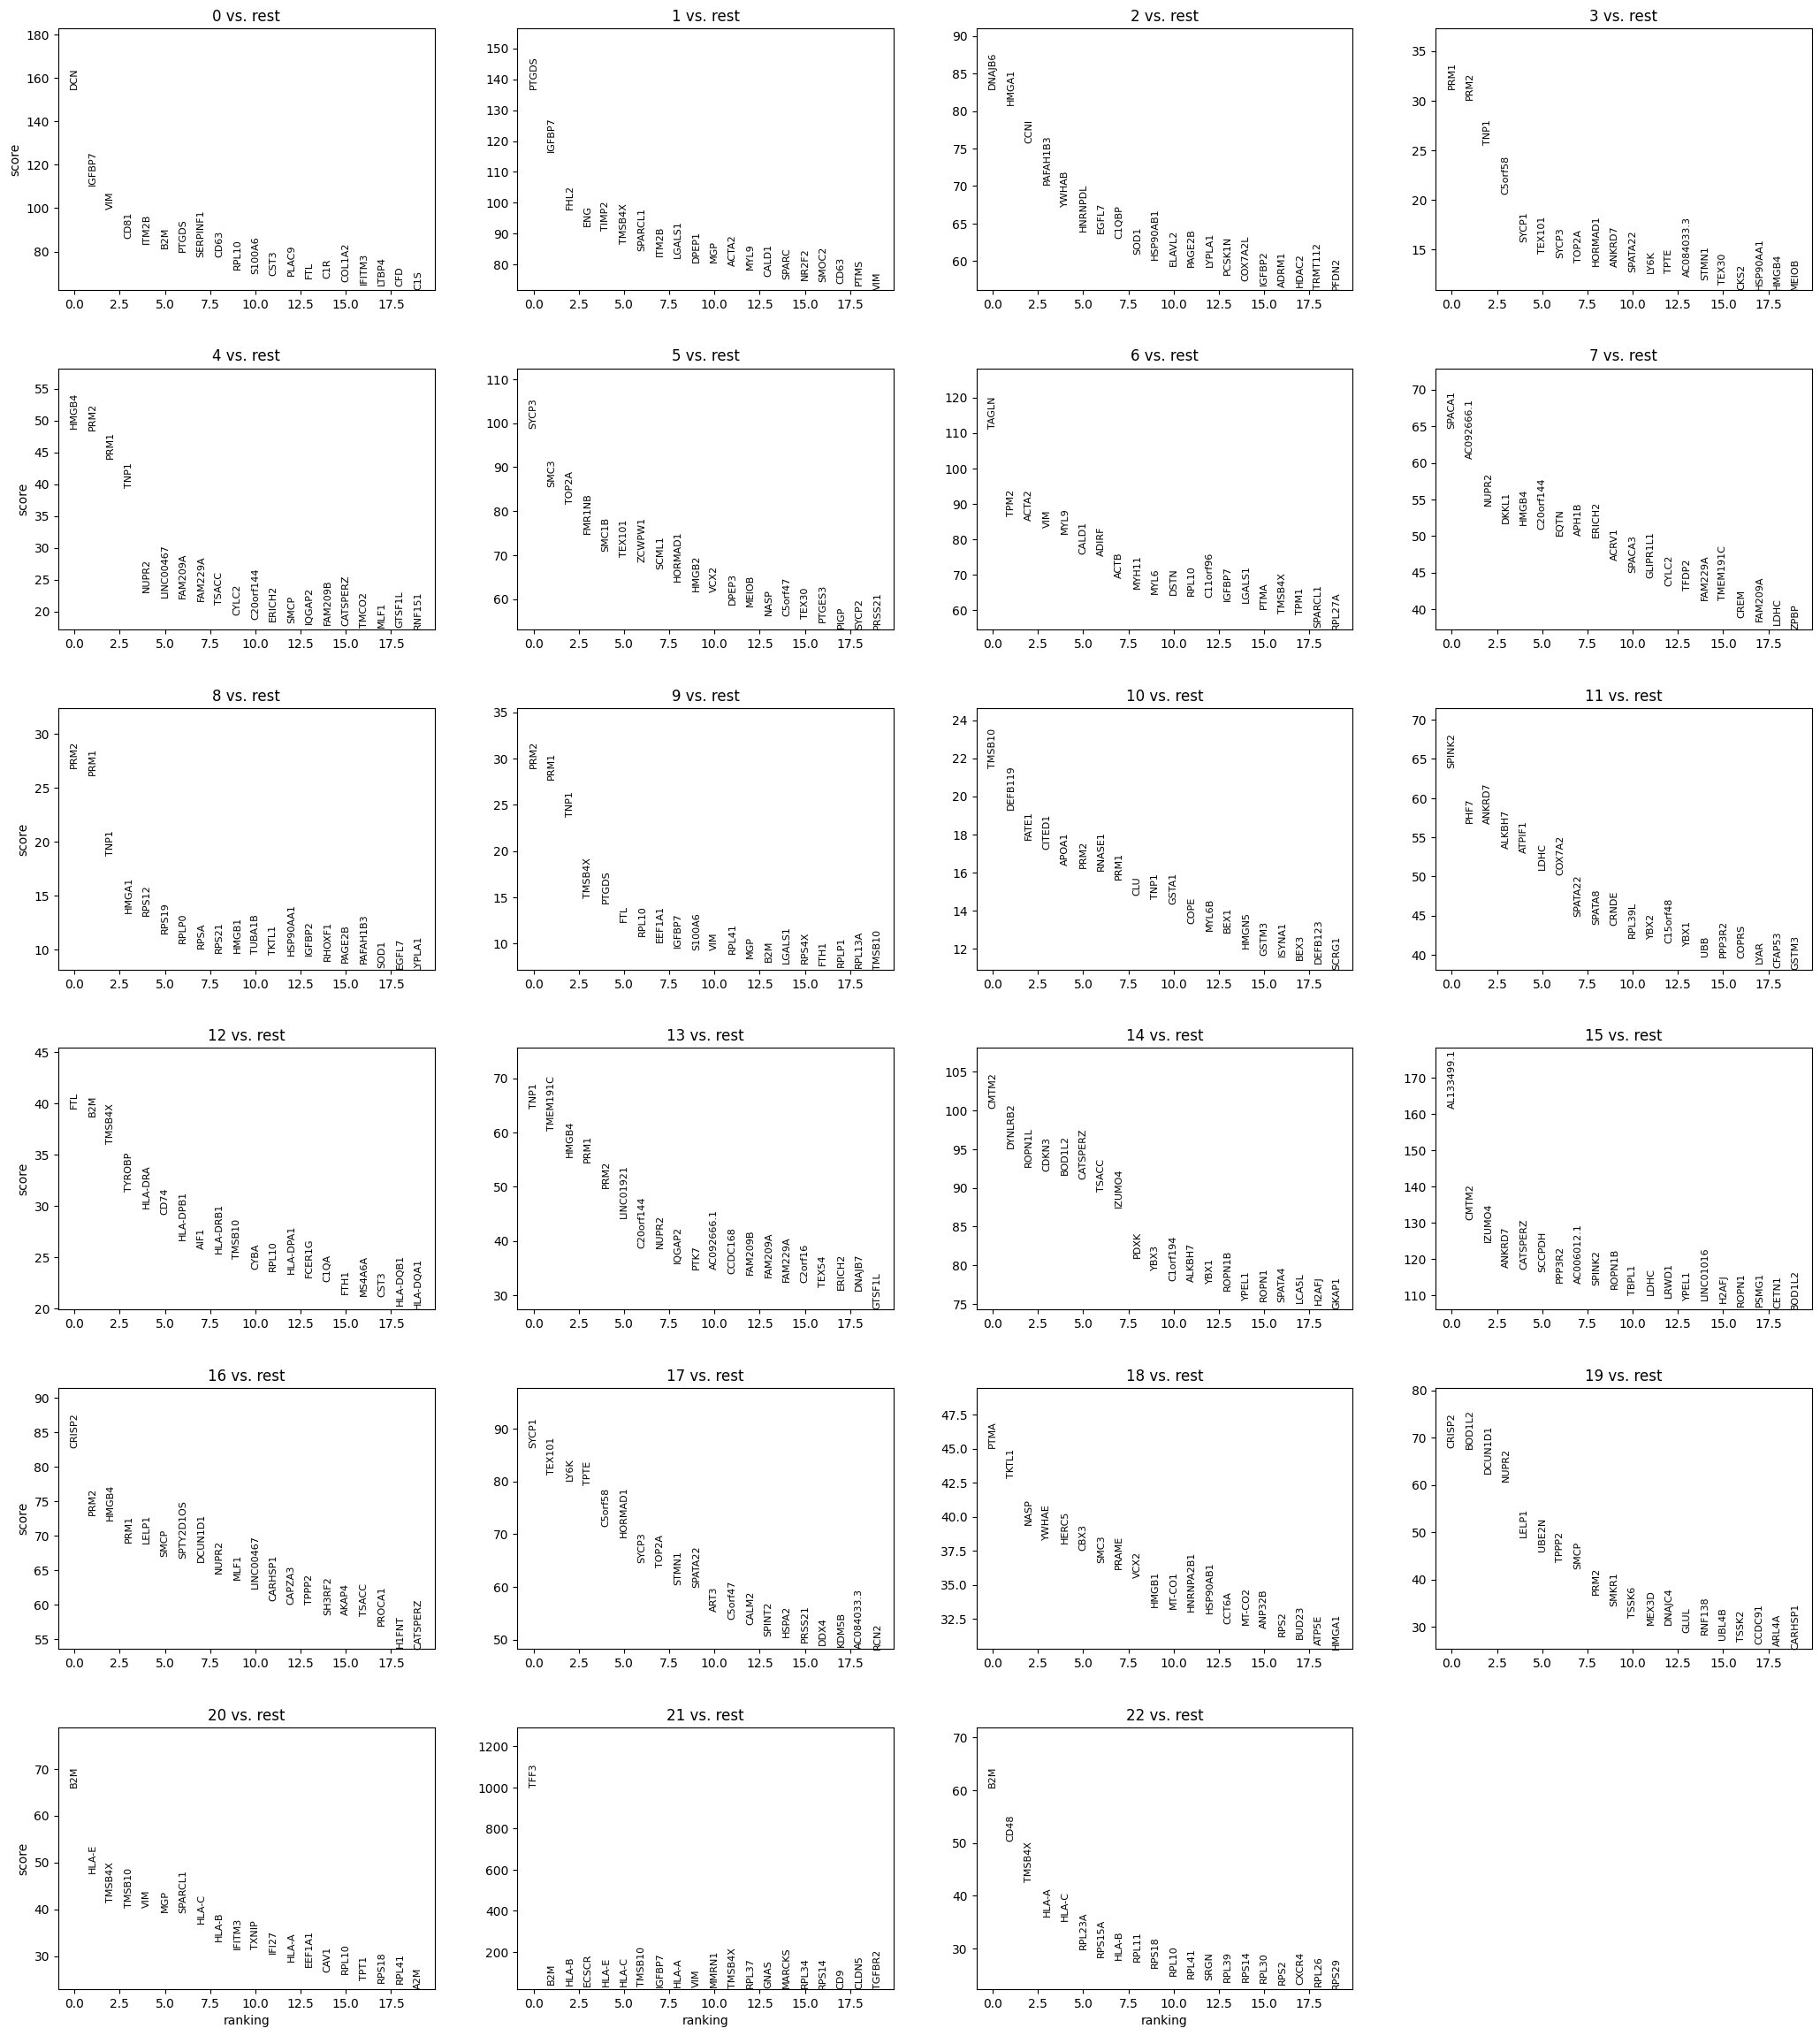

In [26]:
sc.pl.rank_genes_groups(adata, n_genes = 20, sharey = False)

In [27]:
adata = adata[~adata.obs.leiden.isin(["22"])] #ribosomal markers, potentially also 8 and 9. ~ is bitwise not; true -> false


In [28]:
marker_genes = {
    marker_genes = {
    #Overview
    "Sertoli": ["SOX9","GATA1","ACSL4","WT1","GAS6","VIM","CD99", "APOA1"],
    "Leydig": ["CFD","IGF1","IGFBP5","INSL3"], 
    "Myoid": ["MYH11", "ACTA2"],
    "Macrophage": ["CD68", "CD163", "MSR1", "CD14"], 
    "Endothelial": ["VWF", "SOX17"],
    "B": ["CD52"],
    "Mast": ["TPSB2"],
    "T": ["CCL5"],
    "Plasma": ["IGLC2"],
    "PMC": ["DPEP1"],
    "Schwann": ["S100B"],
    "Smooth muscle": ["TAGLN"],
    #"Germ": ["CRNDE"]

    #Germline specific stages, SPG: Spermatogonia, SC: Spermatocytes, SD: Spermatid.
    "SSC1.SPG": ["ID4", "UTF1", "TWIST1", "KRT18", "AES", "ENHO", "C19orf84", "SIX1", "PIWIL4"], #ENH0
    "SSC2.SPG":["ASB9", "L1TD1", "NANOS3", "FAM25G", "CITED2"],
    "Diffing.SPG": ["MKI67", "ACTL8", "KLHL15", "DMRT1", "PABPC4"],
    "Diffed.SPG": ["SSX3", "TEX19", "PNMA6E", "PEG10", "TKTL1", "BEND2"],
    "PreLeptotene.SC": ["DPH7", "PRDM9", "PRAP1", "KIF1A", "MAGEA9B", "FAM9C", "ATP6AP1", "OTUD6A", "CCNB3", "BEND2"], 
    "Leptotene.Zygotene.SC": ["LINC00668", "AP000350.6", "LINC01120", "AL138889.1", "LINC00865", "C18orf63"], 
    "Pachytene.SC": ["PCDHB6", "POM121L12", "POM121L2", "C9orf57", "AL133279.3", "AC093326.2", "AL353581.1", "PCDHB5", "PCDHB2", "AC135012.2", "MNS1", "CCDC42"],
    "Diplotene.SC": ["ART5", "KLB", "B3GALT4", "ELMO3", "RTN4RL2", "AC073263.2", "LINC00588", "WNT6", "LINC01309", "AL121936.1", "KRT72", "LDHC"],
    "Early.Round.SD": ["FAM24A","SPACA1","LINC01351","ABRA","LINC00703","LINC02502","PPP1R27","H1F0","TPRG1","LRRC39","C1orf87","TMIGD3"],
    "Round.SD": ["TNP2","LINC02314","LINC01921","PRSS37","FBXO39","LINC02400","DHRS3","FAM205C","CXorf65","SCP2D1","LINC01548","CCDC179","AC010255.3","SPEM3"], #AC113189.2 -> SPEM3
    "Elongated.SD": ["TSSK6","CABS1","SPATA3","CCDC196","TSPAN16","PHOSPHO1","SPEM2","TEX44","LRRD1","SPEM1","GLUL"] #FLJ40194
    # "Sertoli": ["SOX9","GATA1","ACSL4","WT1","GAS6","VIM","CD99"],
    # "Leydig": ["CFD","IGF1","IGFBP5","INSL3"], 
    # "Myoid": ["MYH11", "ACTA2"],
    # "Macrophage": ["CD68", "CD163", "MSR1"], 
    # "Endothelial": ["VWF", "SOX17"],
    # #"her.somat": ["CD34","TM4SF1","TAGLN"],
    # "Undiff.Spermatogonia": ["PIWIL3","KHDRBS2","CALN1","FGFR3","SLC22A2","PIWIL4","NRG3"],
    # "Diff.Spermatogonia": ["SDF2L1","HELLS","DMRT1", "SYCP3"],
    # "Leptotene.SC": ["GPAT2","DMC1","SYCE1"], 
    # "Zygotene.SC": ["SYCP1"], 
    # "Pachytene.SC": ["PIWIL1","NME5","ADAM2","PROK2"],
    # "Early.Round-SD": ["AURKA","TBPL1","SNRPC"],
    # "Round.SD": ["LYZL6","PSD3","SLC16A7","TBC1D21","TMEM144","ACRV1","FTMT","LYZL4","SPATA9","TULP2","HMGB4","ACTL7A", "TEX29", "SUN5"],
    # "Elongated.SD": ["GABBR2","NRBP1","PRM1","PRM2","TNP1","BAG1"]
    }


In [29]:
def marker_score(markers_dict, adata, N_samples=100, random_seed=42): #Taken from NGS 2025 course pythonScript.py
    np.random.seed(random_seed)
    markers_list = []
    N_genes = adata.shape[1]
    random_genes = np.unique( np.random.randint(low=0, high=N_genes, size=N_samples) )
    gene_names = adata.var_names[random_genes]
    for i in markers_dict:
        markers_list.append(f'{i}_score')
        adata.obs[f'{i}_score'] = np.array(np.mean(adata[:,markers_dict[i]].X,1) - np.mean(adata[:,gene_names].X,(0,1)))
    return markers_list, adata

In [30]:
marker_scores, adata = marker_score(marker_genes, adata)

/tmp/6167662/ipykernel_1982237/1646262721.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[f'{i}_score'] = np.array(np.mean(adata[:,markers_dict[i]].X,1) - np.mean(adata[:,gene_names].X,(0,1)))


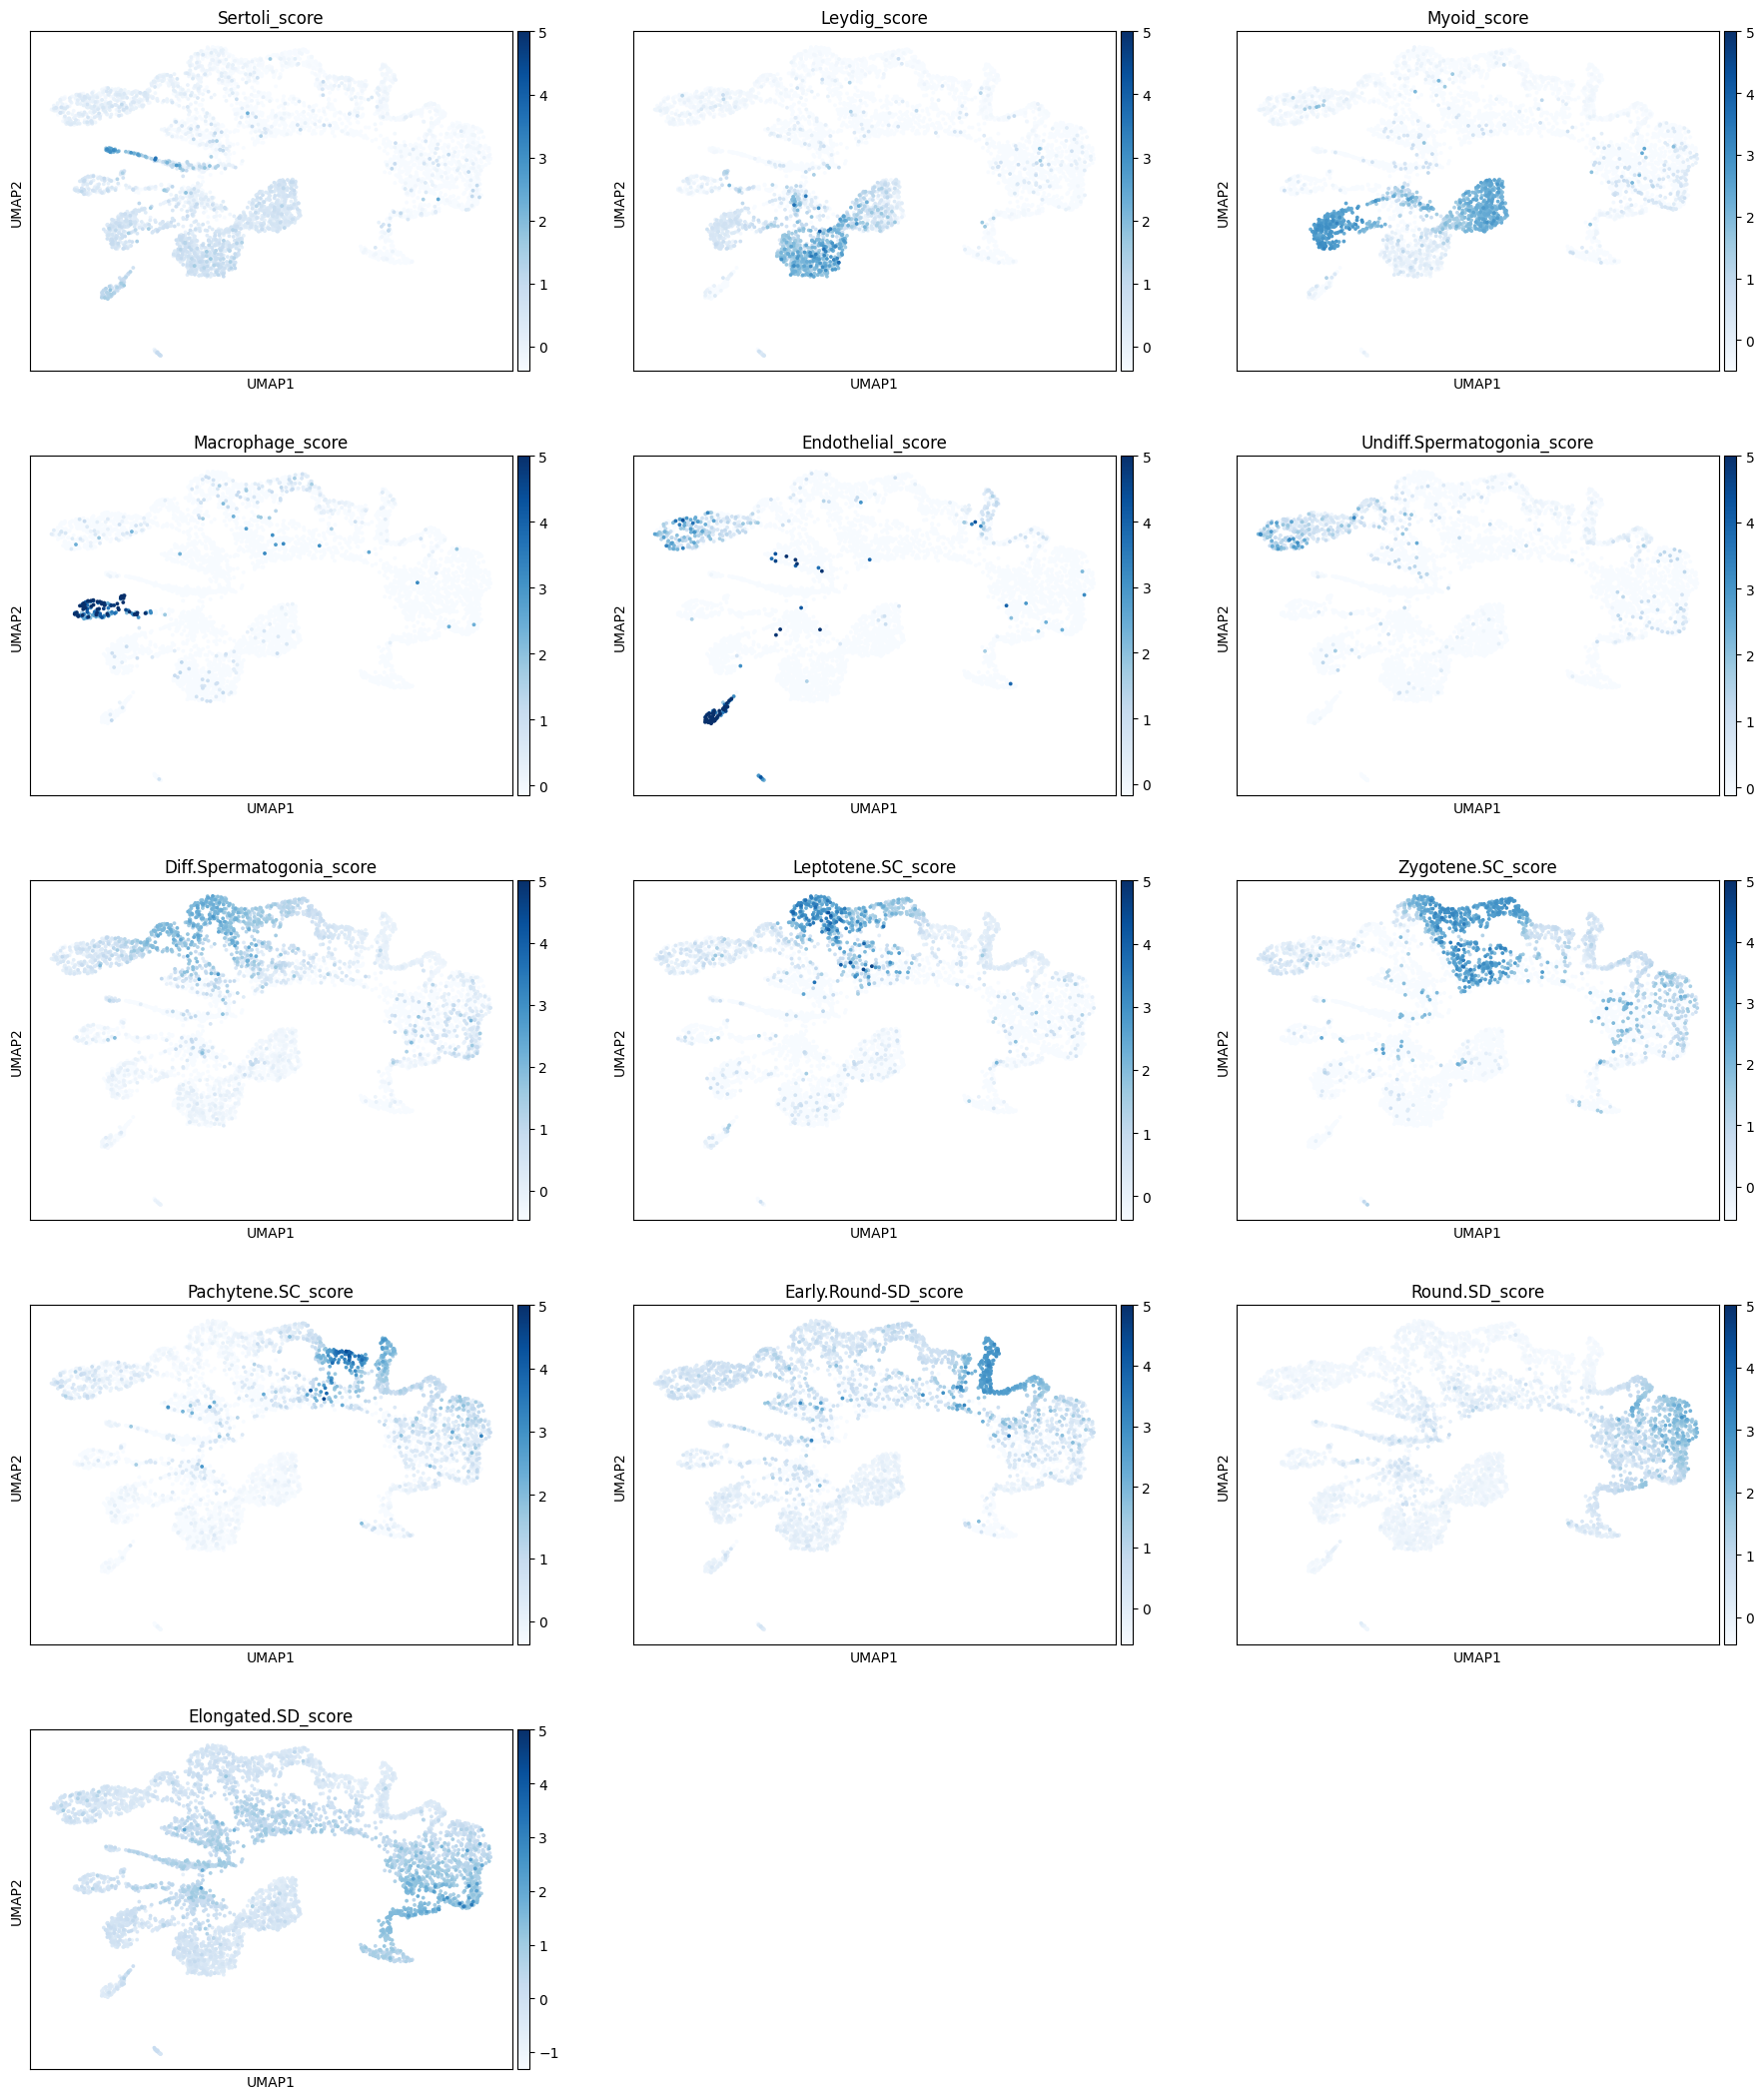

In [31]:
sc.pl.umap(adata, color=marker_scores, components = ['1,2'], ncols = 3, vmax = 5, s=30, cmap = 'Blues')

categories: 0, 1, 2, etc.
var_group_labels: Sertoli, Leydig, Myoid, etc.


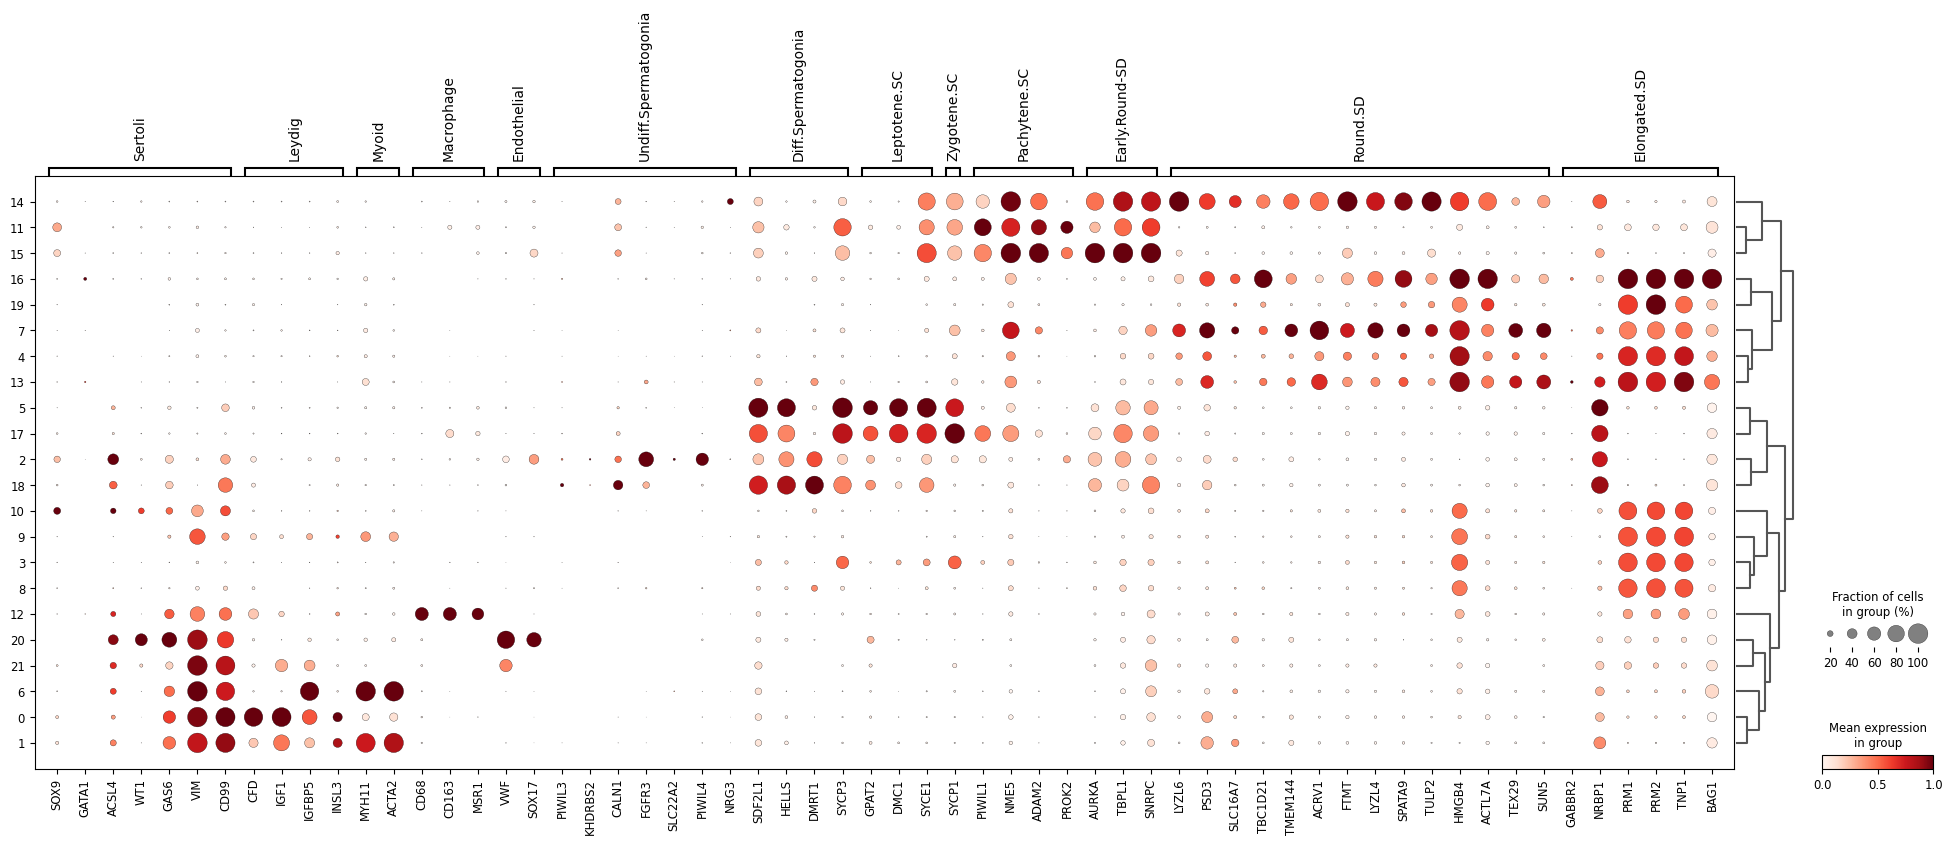

In [32]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    var_names = marker_genes,
    standard_scale = 'var'
)

In [33]:
def clustersByScores(adata, markers_scores, leidenClusters): #from NGS 2025 pythonScripts
    clusters = pd.Categorical(leidenClusters)
    scoresTable = adata.obs[markers_scores]
    clusterUnique = np.unique(leidenClusters)
    newNames = pd.Series(index=leidenClusters)
    for CLST in clusterUnique:
        meanScores = np.mean( scoresTable.loc[leidenClusters==CLST,:], 0)
        newId = meanScores.index[ np.argmax(meanScores) ].split('_')[0]
        newNames[CLST] = newId
    return(pd.Categorical(newNames))

In [34]:
adata.obs['celltype_leiden'] = clustersByScores(adata, marker_scores, adata.obs["leiden"])
#adata.obs.leiden.astype("str").values

/tmp/6167662/ipykernel_1982237/1796372152.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Leydig' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  newNames[CLST] = newId


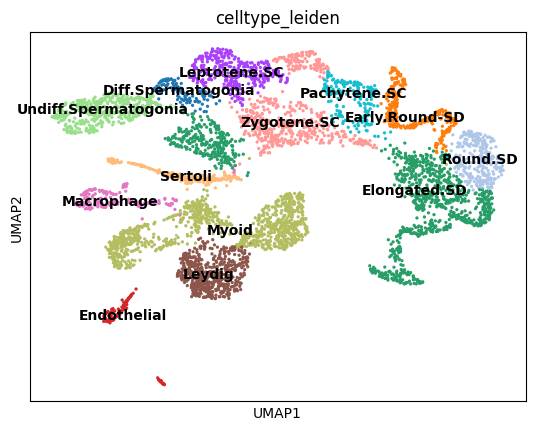

In [35]:
sc.pl.umap(adata, color = ["celltype_leiden"], legend_loc = "on data", components = ['1,2'])

# Cell annotation using CellAssign

In [36]:
celltype_markers = pd.read_csv("/faststorage/project/projectsInBioinformatics/workspaces/johan/PIB-johan-olesen/Notebooks/celltype_markers.csv", index_col = 0)
scvi.settings.seed = 0
torch.set_float32_matmul_precision("high")

[rank: 0] Seed set to 0


In [37]:
adata.X = adata.layers["raw_counts"]
bdata = adata[:, celltype_markers.index].copy()

In [38]:
bdata = bdata[bdata.X.sum(axis=1) > 0, :]
bdata = bdata[:, bdata.X.sum(axis=0) >0]

celltype_markers = celltype_markers.loc[celltype_markers.index.intersection(bdata.var_names)]
bdata = bdata[:, bdata.var_names.isin(celltype_markers.index)].copy()

In [39]:
CellAssign.setup_anndata(bdata, size_factor_key = "size_factor")

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [40]:
NOA1_model = CellAssign(bdata, celltype_markers)

In [41]:
NOA1_model.train(accelerator="cuda")

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.13 /home/jool/miniforge3/envs/torch/lib/python3.13/ ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.13 /home/jool/miniforge3/envs/torch/lib/python3.13/ ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (5) is s

Epoch 400/400: 100%|███████████████████████████████████████████| 400/400 [00:28<00:00, 12.03it/s, v_num=1, train_loss=59]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████████████| 400/400 [00:28<00:00, 14.26it/s, v_num=1, train_loss=59]


<Axes: xlabel='epoch'>

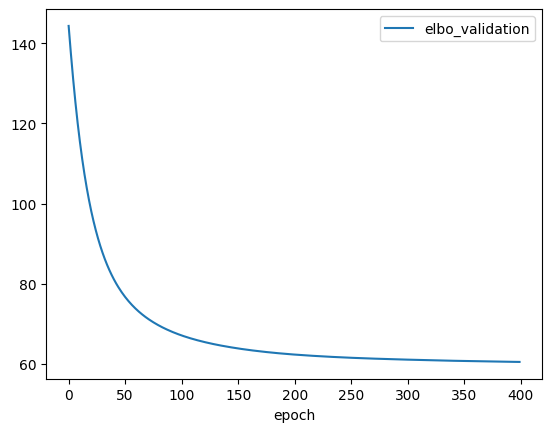

In [42]:
NOA1_model.history["elbo_validation"].plot()

In [43]:
predictions = NOA1_model.predict()
predictions.head()

,Sertoli,Leydig,Myoid,Macrophage,Endothelial,Undiff.Spermatogonia,Diff.Spermatogonia,Leptotene.SC,Zygotene.SC,Pachytene.SC,Early.Round.SD,Round.SD,Elongated.SD
0,2.844646e-04,2.714495e-03,4.624513e-02,3.005911e-03,3.874937e-02,5.232948e-02,7.945734e-01,1.312254e-03,1.804159e-02,4.970715e-03,3.607212e-02,5.750172e-07,1.700140e-03
1,1.007717e-13,1.317158e-12,9.159013e-12,1.010339e-12,3.933266e-12,1.555542e-11,1.000000e+00,5.909424e-11,4.951030e-12,1.467435e-12,7.876491e-12,7.064629e-16,2.236189e-12
2,7.537672e-06,3.835635e-05,1.932089e-04,6.849010e-05,1.125675e-04,3.343996e-04,9.974398e-01,3.155599e-06,5.812147e-05,8.557548e-05,1.387957e-04,6.919438e-06,1.511721e-03
3,9.332738e-07,1.517624e-05,2.162921e-04,1.053251e-05,1.883923e-03,9.949545e-01,2.078388e-03,1.048920e-05,1.086432e-04,3.877358e-04,3.024162e-04,5.470253e-09,3.015026e-05
4,9.752109e-10,8.894399e-06,9.999924e-01,1.112079e-09,3.192767e-09,6.473970e-09,8.172883e-09,7.461783e-11,3.155522e-09,1.121168e-09,3.030032e-09,6.092082e-11,1.491962e-09


/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


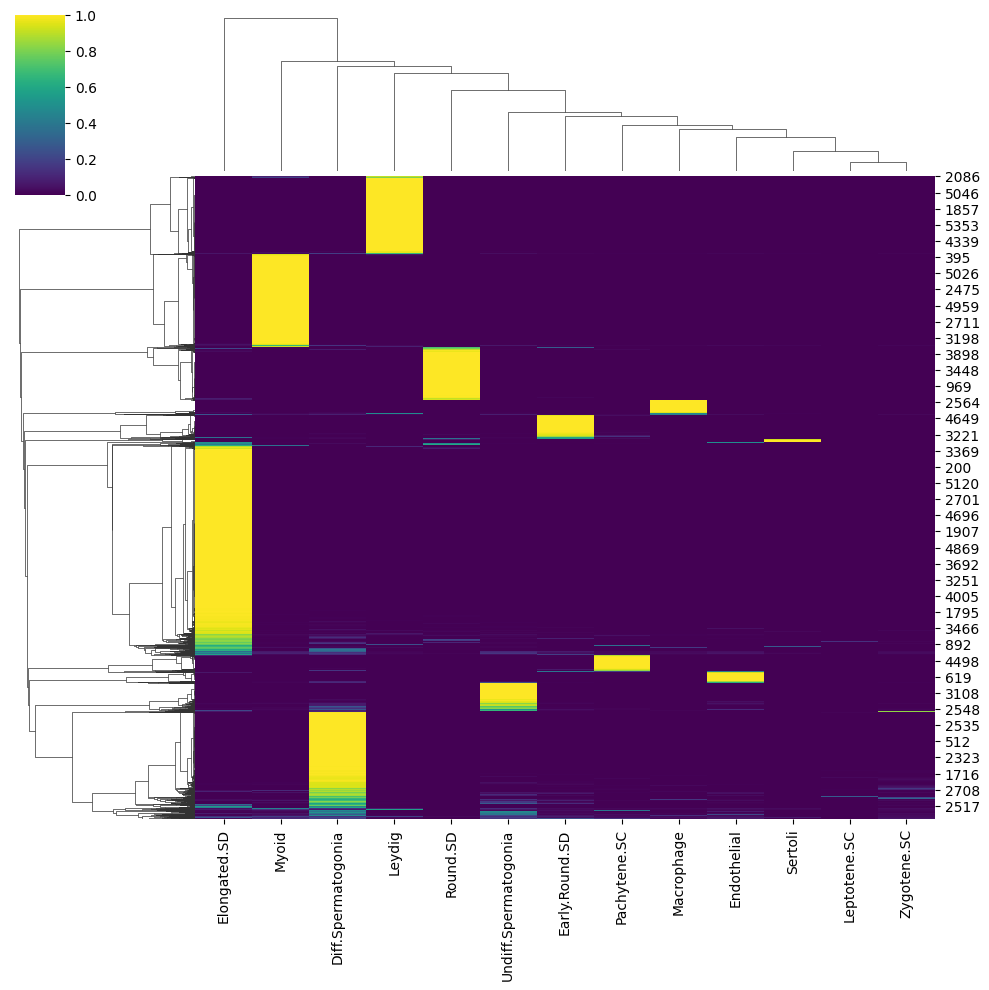

In [44]:
sns.clustermap(predictions, cmap = "viridis")

In [45]:
bdata.obs["celltype_CellAssign"] = predictions.idxmax(axis=1).values

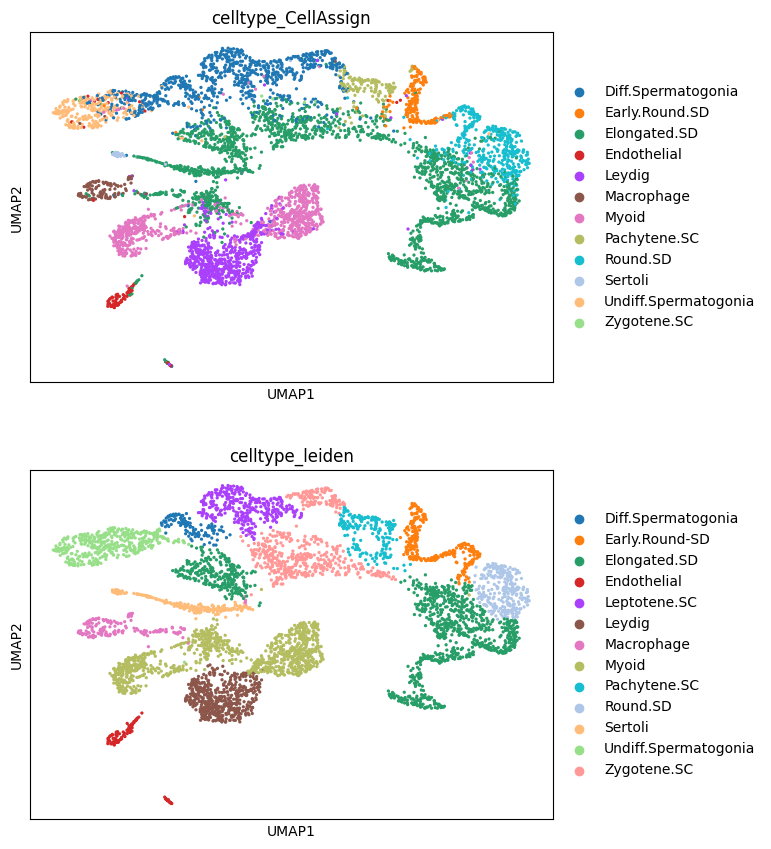

In [46]:
sc.pl.umap(bdata, color = ["celltype_CellAssign", "celltype_leiden"], ncols = 1)

In [47]:
def describe_counts(adata):
    total_counts = np.array(adata.X.sum(axis=1)).flatten()
    print("Cells:", adata.n_obs, "Genes:", adata.n_vars)
    print("Min total counts:", total_counts.min())
    print("Max total counts:", total_counts.max())
    print("Mean total counts:", total_counts.mean())
    print("Fraction zero-count cells:", (total_counts == 0).mean())

#describe_counts(bdata)

In [48]:
NOA1_model.save("/faststorage/project/projectsInBioinformatics/workspace/johan/PIB-johan-olesen/Notebooks/CellAssign_models", prefix = "NOA1", overwrite = False)

ValueError: /faststorage/project/projectsInBioinformatics/workspace/johan/PIB-johan-olesen/Notebooks/CellAssign_models already exists. Please provide another directory for saving.